In [1]:
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad as integral
from collections import OrderedDict
from scipy.stats import kstest
from scipy import stats
from scipy.stats import multivariate_normal as multinorm
import pandas as pd
from time import time,strftime
import spiceypy as spy
#Time
TIME=time()
%matplotlib nbagg

In [2]:
%matplotlib nbagg

In [3]:
BDIR=f"./"

In [4]:
FIGDIR=f"{BDIR}/figures/"

## Useful routines

In [7]:
def flatten(iterable):
    try:
        iterator = iter(iterable)
    except TypeError:
        yield iterable
    else:
        for element in iterator:
            yield from flatten(element)

def linearCovariance(scales,angles):
    """
    Get the covariance matrix of a multivariate gaussian in R^3 as a linear transformation (rotation)
    """
    import spiceypy as spy
    import numpy as np
    covs=[]
    for scale,angle in zip(scales,angles):
        L=np.identity(len(scale))*np.outer(np.ones(len(scale)),scale)
        R=spy.eul2m(-angle[0],-angle[1],-angle[2],3,1,3)
        covs+=[spy.mxm(spy.mxm(R,spy.mxm(L,L)),spy.invert(R))]
    return covs

def multiNorm3D(r,params,verbose=False):
    """
    p(r;w,mu,s,a) = \Sum_i w_i G(r,mu_i,s_i,cov_i)
    """
    #Check if it is one function
    #Unflatten parameters
    N=len(params)
    if N>9:
        M=np.int((len(params)+1)/10)
        i=0;j=i+M-1
        weights=list(params[i:j])+[1-sum(params[i:j])]
    else:
        #Case for one function
        M=1
        weights=[1.0]
        j=0
    i=j;j=i+3*M
    locs=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    scales=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    angles=np.reshape(params[i:j],(M,3))

    #Generate covariance matrices
    covs=linearCovariance(scales,angles)    

    if verbose:
        print("Weights:",weights)
        print("Locations:",locs)
        print("Scales:",scales)
        print("Covariances:",covs)
    
    #Compute function
    value=0
    for w,loc,cov in zip(weights,locs,covs):
        value+=w*multinorm.pdf(r,loc,cov)
    return value

def multiNorm3DMarginal(vf,params,v1,v2,perm):
    """
    Marginal.
    
    vf: Value of the main variable.
    v1,v2: Value of the marginalized variables.
    perm: order on which the variables should be passed to the multiNorm3D funcition.
      Ex. perm=[1,2,3], vf will be x (1), v1 will be y, v2 will be z
          perm=[2,3,1], vf will be z, v1 will be x, v2 will be y
    """
    v=[vf,v1,v2]
    r=[v[perm[0]-1],v[perm[1]-1],v[perm[2]-1]]
    p=multiNorm3D(r,params)
    return p

def map2Inf(x,scale=1):
    """
    Map variable x from the interval [0,scale] to a new variable t in the interval [-inf,+inf].
    x = 0 correspond to t->-inf
    x = 1 correspond to t->+inf
    """
    u=x/scale
    t=np.log(u/(1-u))
    return t

def map2Fin(t,scale=1):
    """
    Map variable t from the interval (-inf,inf) to a new variable x in the interval [0,scale].
    t->-inf correspond to x = 0
    t->+inf correspond to x = 1
    """
    x=scale/(1+np.exp(-t))
    return x

def logLikelihood(params,data,pdf,**args):
    logL=0
    for point in data:
        p=pdf(point,params,**args)
        logp=np.log10(p)
        logL-=logp
    return logL

def elTime(verbose=True):
    global TIME
    t=time()
    dt=t-TIME
    if verbose:print("%.3f s, %.3f min, %g h"%(dt,dt/60.0,dt/3600.0))
    TIME=t

DEG=np.pi/180

## Test routines

In [6]:
#Parameters
#Weights
weights=[0.8]
#(mu_x,mu_y,mu_z)
locs=[[0,0,0],[1.5,1.5,1.5]]
#(sigma_x,sigma_y,sigma_z)
scales=[[1.0,0.2,0.4],[0.2,0.2,1.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[30*DEG,-45*DEG,60*DEG],[0.0,0.0,0.0]]
params=list(flatten(weights+locs+scales+angles))

In [7]:
multiNorm3D([0,0,0],params,verbose=True)

Weights: [0.8, 0.19999999999999996]
Locations: [[0.  0.  0. ]
 [1.5 1.5 1.5]]
Scales: [[1.  0.2 0.4]
 [0.2 0.2 1. ]]
Covariances: [array([[ 0.07044156,  0.0690271 , -0.10455844],
       [ 0.0690271 ,  0.66955844, -0.40677701],
       [-0.10455844, -0.40677701,  0.46      ]]), array([[0.04, 0.  , 0.  ],
       [0.  , 0.04, 0.  ],
       [0.  , 0.  , 1.  ]])]


0.6349363593424098

In [8]:
%timeit -n 1000 multiNorm3D([0,0,0],params)

1000 loops, best of 3: 911 µs per loop


In [9]:
multiNorm3DMarginal(0,params,0,0,[1,2,3])

0.6349363593424098

In [10]:
%timeit -n 1000 multiNorm3DMarginal(0,params,0,0,[1,2,3])

1000 loops, best of 3: 921 µs per loop


## Load data 

In [11]:
data=np.loadtxt("NEOs.txt")
neos=pd.DataFrame(data,columns=["q","e","i","sini","a","W","w"])
neos["Q"]=map2Inf(neos["q"],1)
neos["E"]=map2Inf(neos["e"],1)
neos["I"]=map2Inf(neos["i"],180)
data=neos[["Q","E","I"]].as_matrix()
neos.describe()

,q,e,i,sini,a,W,w,Q,E,I
count,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000
mean,0.678313,0.591753,21.128338,0.346668,1.817262,172.558561,181.041693,1.072005,0.420269,-2.274073
std,0.223048,0.171053,14.366254,0.212230,0.682294,104.174156,105.831543,1.454913,0.808675,0.879910
min,0.081881,0.071638,0.146150,0.002551,0.549695,0.086510,0.019390,-2.417053,-2.561790,-7.115266
25%,0.516611,0.480041,9.992375,0.173517,1.348770,81.549932,90.734375,0.066470,-0.079880,-2.834024
50%,0.708250,0.606480,17.979020,0.308669,1.783858,165.625325,183.691945,0.886898,0.432539,-2.198520
75%,0.870225,0.716947,29.257705,0.488342,2.235777,262.921038,273.216085,1.902952,0.929368,-1.639429
max,0.999555,0.968381,154.366840,0.967612,17.786568,359.862750,359.918740,7.717666,3.421877,1.795445


<IPython.core.display.Javascript object>


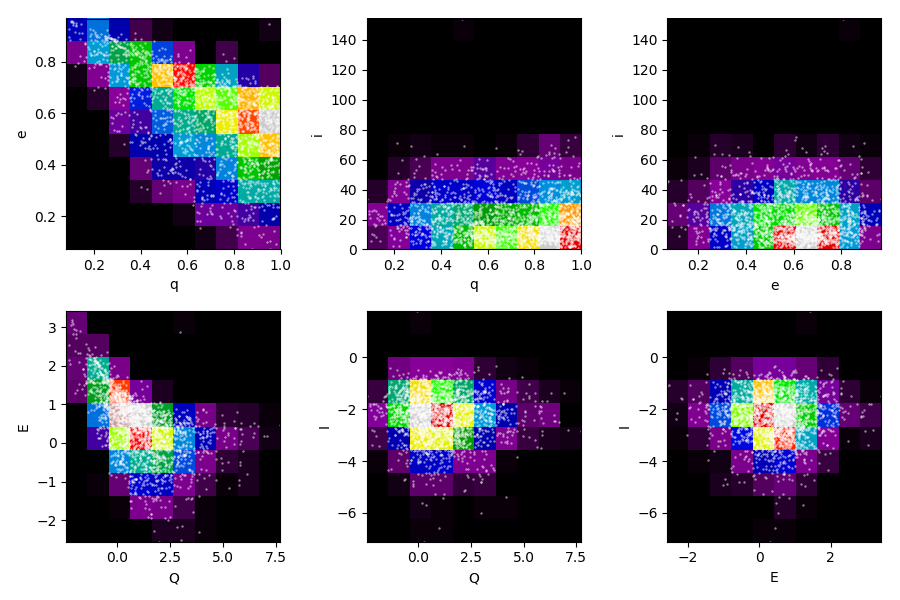

In [12]:
#Plot
fig,axs=plt.subplots(2,3,figsize=(9,6))

qcont=1
pargs=dict(color='w' if qcont else 'k',ls='None',marker='+',ms=2,alpha=0.5)
hargs=dict(cmap="nipy_spectral")
pairs=[["q","e"],["q","i"],["e","i"]]

for n,pair in enumerate(pairs):
    q1=pair[0]
    q2=pair[1]
    ax=axs[0,n]
    if qcont:ax.hist2d(neos[q1],neos[q2],**hargs)
    ax.plot(neos[q1],neos[q2],**pargs)
    ax.set_xlabel(q1);ax.set_ylabel(q2)

hargs=dict(cmap="nipy_spectral")
pargs=dict(color='w' if qcont else 'k',ls='None',marker='+',ms=2,alpha=0.5)
pairs=[["Q","E"],["Q","I"],["E","I"]]

for n,pair in enumerate(pairs):
    q1=pair[0]
    q2=pair[1]
    ax=axs[1,n]
    if qcont:ax.hist2d(neos[q1],neos[q2],**hargs)
    ax.plot(neos[q1],neos[q2],**pargs)
    ax.set_xlabel(q1);ax.set_ylabel(q2)
        
fig.tight_layout()

## Plot data and theoretical function

In [13]:
#Parameters
#Weights
weights=[]
#(mu_x,mu_y,mu_z)
locs=[[0,1,-2]]
#(sigma_x,sigma_y,sigma_z)
scales=[[2.5,2.0,2.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[0*DEG,0*DEG,0*DEG]]
params=list(flatten(weights+locs+scales+angles))

In [14]:
multiNorm3D([0,0,0],params,verbose=True)

Weights: [1.0]
Locations: [[ 0  1 -2]]
Scales: [[2.5 2.  2. ]]
Covariances: [array([[6.25, 0.  , 0.  ],
       [0.  , 4.  , 0.  ],
       [0.  , 0.  , 4.  ]])]


0.0033985694272026527

In [ ]:
NX=NY=NZ=15
vmax=6
xvec=np.linspace(-vmax,vmax,NX)
yvec=np.linspace(-vmax,vmax,NY)
zvec=np.linspace(-vmax,vmax,NZ)
Xxy,Yxy=np.meshgrid(xvec,yvec)
Xxz,Zxz=np.meshgrid(xvec,zvec)
Yyz,Zyz=np.meshgrid(yvec,zvec)

PXY=np.zeros((NX,NY))
for i,x in enumerate(xvec):
    for j,y in enumerate(yvec):
        PXY[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,x,y,[2,3,1]))[0]
        
PXZ=np.zeros((NX,NZ))
for i,x in enumerate(xvec):
    for j,z in enumerate(zvec):
        PXZ[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,x,z,[2,1,3]))[0]

PYZ=np.zeros((NY,NZ))
for i,y in enumerate(yvec):
    for j,z in enumerate(zvec):
        PYZ[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,y,z,[1,2,3]))[0]

In [ ]:
vmax=6
ndata=10

fig,axs=plt.subplots(1,3,figsize=(9,3))

pargs=dict(color='k',ls='None',marker='s',ms=5,alpha=0.5)
hargs=dict(cmap="nipy_spectral")

i=-1

i+=1
axs[i].contourf(Xxy,Yxy,PXY,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,1],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("E")

i+=1
axs[i].contourf(Xxz,Zxz,PXZ,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,2],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("I")

i+=1
axs[i].contourf(Yyz,Zyz,PYZ,**hargs)
axs[i].plot(data[:ndata,1],data[:ndata,2],**pargs)
axs[i].set_xlabel("E")
axs[i].set_ylabel("I")

for ax in axs:
    ax.grid()
    ax.set_xlim((-vmax,vmax))
    ax.set_ylim((-vmax,vmax))
    
fig.tight_layout()

## Likelihood

In [19]:
def logLikelihood(params,data,pdf,**args):
    logL=0
    for point in data:
        p=pdf(point,params,**args)
        logp=np.log10(p)
        logL-=logp
    return logL

In [20]:
def flattenParams(weights,locs,scales,angles):
    M=len(locs)
    params=list(flatten(weights+locs+scales+angles))
    #Constrainst on weights
    wbnds=(0,1),
    maxls=10
    lbnds=(-maxls,maxls),
    sbnds=(1e-3,maxls),
    abnds=(-180*DEG,180*DEG),
    bounds=()
    if M>1:
        bounds=wbnds*(M-1)
    bounds+=lbnds*M*3+sbnds*M*3+abnds*M*3
    return params,bounds

In [21]:
elTime(False)
"""
######################################################
#1 FUNCTION
######################################################
#Parameters
#Weights
weights=[]
#(mu_x,mu_y,mu_z)
locs=[[0,1,-2]]
#(sigma_x,sigma_y,sigma_z)
scales=[[2.5,2.0,2.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[0*DEG,0*DEG,0*DEG]]
#"""
#"""
######################################################
#2 FUNCTIONS
######################################################
#Parameters
#Weights
weights=[0.8]
#(mu_x,mu_y,mu_z)
locs=[[0,0,0],[1.5,1.5,1.5]]
#(sigma_x,sigma_y,sigma_z)
scales=[[1.0,0.2,0.4],[0.2,0.2,1.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[30*DEG,-45*DEG,60*DEG],[0.0,0.0,0.0]]
#"""
#ndata=1000
ndata=len(data)

params,bnds=flattenParams(weights,locs,scales,angles)
len(params),params,bnds,len(bnds)
elTime()

0.000 s, 0.000 min, 1.23845e-07 h


In [22]:
bnds

((0, 1),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (0.001, 10),
 (0.001, 10),
 (0.001, 10),
 (0.001, 10),
 (0.001, 10),
 (0.001, 10),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793))

In [23]:
elTime(False)
print(logLikelihood(params,data[:ndata],multiNorm3D))
#%timeit logLikelihood(params,data[:ndata],multiNorm3D)
elTime(True)

32331.510108566854
2.524 s, 0.042 min, 0.000701177 h


In [114]:
ndata=len(data)

In [115]:
elTime(False)
solution=minimize(logLikelihood,params,args=(data[:ndata],multiNorm3D),method="SLSQP",bounds=bnds)
elTime(True)
solution

/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


2020.699 s, 33.678 min, 0.561305 h


     fun: 3735.0098976714735
     jac: array([ 1.46484375e-03, -1.98364258e-03, -1.86157227e-03,  1.64794922e-03,
       -3.05175781e-05, -1.12915039e-03,  1.83105469e-04,  3.05175781e-04,
        2.77709961e-03, -5.92041016e-03,  3.23486328e-03,  2.59399414e-03,
        2.56347656e-03,  2.13623047e-03, -1.92260742e-03,  2.77709961e-03,
       -1.22070312e-04, -2.59399414e-03,  1.00708008e-03])
 message: 'Optimization terminated successfully.'
    nfev: 803
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([ 0.64441429,  0.49089214,  0.46506971, -2.07384222,  2.1251291 ,
        0.339077  , -2.6369388 ,  1.30713736,  0.73986239,  0.50556035,
        0.44031391,  0.92792341,  1.55648102, -0.70539896, -1.46084992,
       -0.01199363,  1.40316639, -1.85786271, -0.01481079])

In [ ]:
params=solution.x
print(logLikelihood(params,data[:ndata],multiNorm3D))

In [98]:
#C-solution
#Solution 1:
#params=np.array([0.885829,1.113374,0.533196,-2.381518,0.426707,0.119802,-1.868738,0.909623,1.574238,0.554279,1.385628,0.441669,0.536394,-0.305925,-1.537088,1.587063,2.849182,-2.961536,0.581749,])
#Solution 2:
#params=np.array([0.978749,0.727820,0.533096,-2.327055,3.531666,-0.014446,-2.120380,0.956834,0.492661,1.210173,0.643573,1.136560,2.287491,1.070028,-1.263540,1.461507,1.913151,-1.079603,0.150435,])
#Solution 3:
params=np.array([0.882789,0.697513,0.461961,-2.289290,3.112215,0.254214,-2.204593,1.276335,0.907763,0.544877,0.376731,0.819375,1.571365,-0.593954,-1.443985,0.151859,1.467381,-1.414476,-0.051346,])
#Solution 4:
#params=np.array([0.823319,0.639226,0.605503,-2.346773,2.715741,-0.205313,-2.026252,1.256742,0.491456,0.896668,0.628403,0.691599,1.586910,0.766752,-2.832252,1.275714,1.763586,-1.470599,-0.371470,])
ndata=len(data)
print(logLikelihood(params,data[:ndata],multiNorm3D))

3765.804647440075


In [99]:
NX=NY=NZ=15
vmax=6
xvec=np.linspace(-vmax,vmax,NX)
yvec=np.linspace(-vmax,vmax,NY)
zvec=np.linspace(-vmax,vmax,NZ)
Xxy,Yxy=np.meshgrid(xvec,yvec)
Xxz,Zxz=np.meshgrid(xvec,zvec)
Yyz,Zyz=np.meshgrid(yvec,zvec)

"""
PXY=np.zeros((NX,NY))
for i,x in enumerate(xvec):
    for j,y in enumerate(yvec):
        PXY[j,i]=multiNorm3D([x,y,0],params)
        
PXZ=np.zeros((NX,NZ))
for i,x in enumerate(xvec):
    for j,z in enumerate(zvec):
        PXZ[j,i]=multiNorm3D([x,0,z],params)

PYZ=np.zeros((NY,NZ))
for i,y in enumerate(yvec):
    for j,z in enumerate(zvec):
        PYZ[j,i]=multiNorm3D([0,y,z],params)
#"""
        
        
#"""
PXY=np.zeros((NX,NY))
for i,x in enumerate(xvec):
    for j,y in enumerate(yvec):
        PXY[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,x,y,[2,3,1]))[0]
        
PXZ=np.zeros((NX,NZ))
for i,x in enumerate(xvec):
    for j,z in enumerate(zvec):
        PXZ[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,x,z,[2,1,3]))[0]

PYZ=np.zeros((NY,NZ))
for i,y in enumerate(yvec):
    for j,z in enumerate(zvec):
        PYZ[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,y,z,[1,2,3]))[0]
#"""    

In [100]:
def unflattenParameters(params):
    import spiceypy as spy
    N=len(params)
    if N>9:
        M=np.int((len(params)+1)/10)
        i=0;j=i+M-1
        weights=list(params[i:j])+[1-sum(params[i:j])]
    else:
        #Case for one function
        M=1
        weights=[1.0]
        j=0
    i=j;j=i+3*M
    locs=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    scales=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    angles=np.reshape(params[i:j],(M,3))
    
    rots=[]
    covs=[]
    for scale,angle in zip(scales,angles):
        L=np.identity(len(scale))*np.outer(np.ones(len(scale)),scale)
        rots+=[spy.eul2m(-angle[0],-angle[1],-angle[2],3,1,3)]
        covs+=[spy.mxm(spy.mxm(rots[-1],spy.mxm(L,L)),spy.invert(rots[-1]))]
        
        
    return weights,locs,scales,angles,rots,covs

In [101]:
wsol,locsol,scasol,angsol,rotsol,covsol=unflattenParameters(params)
print(wsol)
print(locsol)
print(scasol)
print(angsol)

[0.882789, 0.11721099999999995]
[[ 0.697513  0.461961 -2.28929 ]
 [ 3.112215  0.254214 -2.204593]]
[[1.276335 0.907763 0.544877]
 [0.376731 0.819375 1.571365]]
[[-0.593954 -1.443985  0.151859]
 [ 1.467381 -1.414476 -0.051346]]


In [102]:
l=locsol[0]
lx=scasol[0][0]
Nx=10
axis=np.zeros((Nx,3))
axis[:,0]=np.linspace(-2*lx,2*lx,Nx)
xaxis1=np.array([spy.mxv(rotsol[0],axis[i,:])+l for i in range(Nx)])

l=locsol[1]
lx=scasol[1][0]
Nx=10
axis=np.zeros((Nx,3))
axis[:,0]=np.linspace(-2*lx,2*lx,Nx)
xaxis2=np.array([spy.mxv(rotsol[0],axis[i,:])+l for i in range(Nx)])

l=locsol[0]
lx=scasol[0][1]
Nx=10
axis=np.zeros((Nx,3))
axis[:,1]=np.linspace(-2*lx,2*lx,Nx)
yaxis1=np.array([spy.mxv(rotsol[0],axis[i,:])+l for i in range(Nx)])

l=locsol[1]
lx=scasol[1][1]
Nx=10
axis=np.zeros((Nx,3))
axis[:,1]=np.linspace(-2*lx,2*lx,Nx)
yaxis2=np.array([spy.mxv(rotsol[0],axis[i,:])+l for i in range(Nx)])

l=locsol[0]
lx=scasol[0][2]
Nx=10
axis=np.zeros((Nx,3))
axis[:,2]=np.linspace(-2*lx,2*lx,Nx)
zaxis1=np.array([spy.mxv(rotsol[0],axis[i,:])+l for i in range(Nx)])

l=locsol[1]
lx=scasol[1][2]
Nx=10
axis=np.zeros((Nx,3))
axis[:,2]=np.linspace(-2*lx,2*lx,Nx)
zaxis2=np.array([spy.mxv(rotsol[0],axis[i,:])+l for i in range(Nx)])

<IPython.core.display.Javascript object>


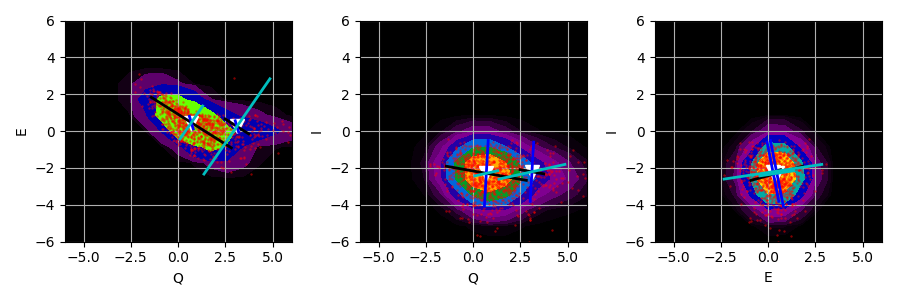

In [103]:
ndata=1000
fig,axs=plt.subplots(1,3,figsize=(9,3))

pargs=dict(color='r',ls='None',marker='+',ms=2,alpha=0.5)
hargs=dict(cmap="nipy_spectral")
cargs=dict(color='w',ls='None',marker='v',ms=10)
aargs=dict(color='y',ls='-',lw=2)

i=-1

i+=1
levels=np.logspace(np.log10(PXY.min()),np.log10(PXY.max()),100)
axs[i].contourf(Xxy,Yxy,PXY,levels=levels,**hargs)
#axs[i].contour(Xxy,Yxy,PXY,levels=levels,alpha=0.2,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,1],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("E")
axs[i].plot(locsol[0][0],locsol[0][1],**cargs)
axs[i].plot(locsol[1][0],locsol[1][1],**cargs)
#axs[i].plot(naxis[:,0],naxis[:,1],**aargs)
axs[i].plot(xaxis1[:,0],xaxis1[:,1],'k-',lw=2)
axs[i].plot(xaxis2[:,0],xaxis2[:,1],'k-',lw=2)
axs[i].plot(yaxis1[:,0],yaxis1[:,1],'b-',lw=2)
axs[i].plot(yaxis2[:,0],yaxis2[:,1],'b-',lw=2)
axs[i].plot(zaxis1[:,0],zaxis1[:,1],'c-',lw=2)
axs[i].plot(zaxis2[:,0],zaxis2[:,1],'c-',lw=2)

i+=1
levels=np.logspace(np.log10(PXZ.min()),np.log10(PXZ.max()),100)
axs[i].contourf(Xxz,Zxz,PXZ,levels=levels,**hargs)
#axs[i].contour(Xxz,Zxz,PXZ,levels=levels,alpha=0.2,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,2],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("I")
axs[i].plot(locsol[0][0],locsol[0][2],**cargs)
axs[i].plot(locsol[1][0],locsol[1][2],**cargs)
axs[i].plot(xaxis1[:,0],xaxis1[:,2],'k-',lw=2)
axs[i].plot(xaxis2[:,0],xaxis2[:,2],'k-',lw=2)
axs[i].plot(yaxis1[:,0],yaxis1[:,2],'b-',lw=2)
axs[i].plot(yaxis2[:,0],yaxis2[:,2],'b-',lw=2)
axs[i].plot(zaxis1[:,0],zaxis1[:,2],'c-',lw=2)
axs[i].plot(zaxis2[:,0],zaxis2[:,2],'c-',lw=2)

i+=1
levels=np.logspace(np.log10(PYZ.min()),np.log10(PYZ.max()),100)
axs[i].contourf(Yyz,Zyz,PYZ,levels=levels,**hargs)
#axs[i].contour(Yyz,Zyz,PYZ,levels=levels,alpha=0.2,**hargs)
axs[i].plot(data[:ndata,1],data[:ndata,2],**pargs)
axs[i].set_xlabel("E")
axs[i].set_ylabel("I")
axs[i].plot(locsol[0][1],locsol[0][2],**cargs)
axs[i].plot(locsol[1][1],locsol[1][2],**cargs)
axs[i].plot(xaxis1[:,1],xaxis1[:,2],'k-',lw=2)
axs[i].plot(xaxis2[:,1],xaxis2[:,2],'k-',lw=2)
axs[i].plot(yaxis1[:,1],yaxis1[:,2],'b-',lw=2)
axs[i].plot(yaxis2[:,1],yaxis2[:,2],'b-',lw=2)
axs[i].plot(zaxis1[:,1],zaxis1[:,2],'c-',lw=2)
axs[i].plot(zaxis2[:,1],zaxis2[:,2],'c-',lw=2)

for ax in axs:
    ax.grid()
    ax.set_xlim((-vmax,vmax))
    ax.set_ylim((-vmax,vmax))
    
fig.tight_layout()

In [38]:
elTime(False)
"""
######################################################
#1 FUNCTION
######################################################
#Parameters
#Weights
weights=[]
#(mu_x,mu_y,mu_z)
locs=[[0,1,-2]]
#(sigma_x,sigma_y,sigma_z)
scales=[[2.5,2.0,2.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[0*DEG,0*DEG,0*DEG]]
#"""
"""
######################################################
#2 FUNCTIONS
######################################################
#Parameters
#Weights
weights=[0.8]
#(mu_x,mu_y,mu_z)
locs=[[0,0,0],[1.5,1.5,1.5]]
#(sigma_x,sigma_y,sigma_z)
scales=[[1.0,0.2,0.4],[0.2,0.2,1.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[30*DEG,-45*DEG,60*DEG],[0.0,0.0,0.0]]
#"""
"""
######################################################
#2 FUNCTIONS
######################################################
#Parameters
#Weights
weights=[0.8]
#(mu_x,mu_y,mu_z)
locs=[[0,0,0],[1.5,1.5,1.5]]
#(sigma_x,sigma_y,sigma_z)
scales=[[1.0,0.2,0.4],[0.2,0.2,1.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[30*DEG,-45*DEG,60*DEG],[0.0,0.0,0.0]]
#"""
#"""
######################################################
#3 FUNCTIONS
######################################################
#Parameters
#Weights
weights=[0.4,0.4]
#(mu_x,mu_y,mu_z)
locs=[[0,0,0],[1.5,1.5,1.5],[-1,-1,-1]]
#(sigma_x,sigma_y,sigma_z)
scales=[[1.0,0.2,0.4],[0.2,0.2,1.0],[0.5,0.4,2.0]]
#(rho_xy,rho_xz,rho_yz)
angles=[[30*DEG,-45*DEG,60*DEG],[0.0,0.0,0.0],[0.0,0.0,0.0]]
#"""

ndata=len(data)

params,bnds=flattenParams(weights,locs,scales,angles)
print(len(params),params,bnds,len(bnds))
elTime()

29 [0.4, 0.4, 0, 0, 0, 1.5, 1.5, 1.5, -1, -1, -1, 1.0, 0.2, 0.4, 0.2, 0.2, 1.0, 0.5, 0.4, 2.0, 0.5235987755982988, -0.7853981633974483, 1.0471975511965976, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ((0, 1), (0, 1), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10), (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)) 29
0.001 s, 0.000 min, 2.28617e-07 h


In [39]:
elTime(False)
print(logLikelihood(params,data[:ndata],multiNorm3D))
#%timeit logLikelihood(params,data[:ndata],multiNorm3D)
elTime(True)

20236.45566806265
3.029 s, 0.050 min, 0.000841274 h


In [40]:
elTime(False)
solution=minimize(logLikelihood,params,args=(data[:ndata],multiNorm3D),method="SLSQP",bounds=bnds)
elTime(True)
solution

/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


8761.738 s, 146.029 min, 2.43382 h


     fun: 3726.871153869874
     jac: array([-1.71646729e+01,  3.87634277e-01, -8.72192383e-02,  2.03002930e-01,
       -2.87536621e-01,  1.79901123e-01,  9.68017578e-02, -6.20422363e-02,
        2.60162354e-01,  1.01281738e+00, -6.46972656e-03, -8.63647461e-02,
        5.95184326e-01, -2.50793457e-01,  1.51397705e-01,  4.19891357e-01,
       -1.12548828e-01,  1.83087158e+00,  9.44396973e-01, -3.80981445e-01,
       -1.02291870e+00, -6.36932373e-01,  8.44421387e-02,  3.22265625e-02,
       -7.11669922e-02, -2.32818604e-01,  1.33605957e-01,  3.01422119e-01,
        3.51989746e-01])
 message: 'Iteration limit exceeded'
    nfev: 3209
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([ 0.00453268,  0.36046732,  0.3549552 ,  0.0147906 , -4.12743912,
        2.10420061,  0.35427543, -2.6240595 ,  0.49151962,  0.46123298,
       -2.06720297,  0.8450759 ,  3.54448734,  0.14021011,  1.55740528,
        0.90988615,  0.4294279 ,  1.31763236,  0.72705035,  0.50418156,
      

In [41]:
#params=solution.x
params=np.array([ 0.00453268,  0.36046732,  0.3549552 ,  0.0147906 , -4.12743912,
        2.10420061,  0.35427543, -2.6240595 ,  0.49151962,  0.46123298,
       -2.06720297,  0.8450759 ,  3.54448734,  0.14021011,  1.55740528,
        0.90988615,  0.4294279 ,  1.31763236,  0.72705035,  0.50418156,
       -1.33959333, -1.56128272,  2.97018557, -0.16801022, -1.54290573,
       -0.26412177, -0.70490326,  1.69288111,  0.01153622])
print(logLikelihood(params,data[:ndata],multiNorm3D))

NX=NY=NZ=15
vmax=6
xvec=np.linspace(-vmax,vmax,NX)
yvec=np.linspace(-vmax,vmax,NY)
zvec=np.linspace(-vmax,vmax,NZ)
Xxy,Yxy=np.meshgrid(xvec,yvec)
Xxz,Zxz=np.meshgrid(xvec,zvec)
Yyz,Zyz=np.meshgrid(yvec,zvec)

"""
PXY=np.zeros((NX,NY))
for i,x in enumerate(xvec):
    for j,y in enumerate(yvec):
        PXY[j,i]=multiNorm3D([x,y,0],params)
        
PXZ=np.zeros((NX,NZ))
for i,x in enumerate(xvec):
    for j,z in enumerate(zvec):
        PXZ[j,i]=multiNorm3D([x,0,z],params)

PYZ=np.zeros((NY,NZ))
for i,y in enumerate(yvec):
    for j,z in enumerate(zvec):
        PYZ[j,i]=multiNorm3D([0,y,z],params)
#"""
        
        
#"""
PXY=np.zeros((NX,NY))
for i,x in enumerate(xvec):
    for j,y in enumerate(yvec):
        PXY[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,x,y,[2,3,1]))[0]
        
PXZ=np.zeros((NX,NZ))
for i,x in enumerate(xvec):
    for j,z in enumerate(zvec):
        PXZ[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,x,z,[2,1,3]))[0]

PYZ=np.zeros((NY,NZ))
for i,y in enumerate(yvec):
    for j,z in enumerate(zvec):
        PYZ[j,i]=integral(multiNorm3DMarginal,-np.inf,np.inf,args=(params,y,z,[1,2,3]))[0]
#"""

3726.871153869874


<IPython.core.display.Javascript object>


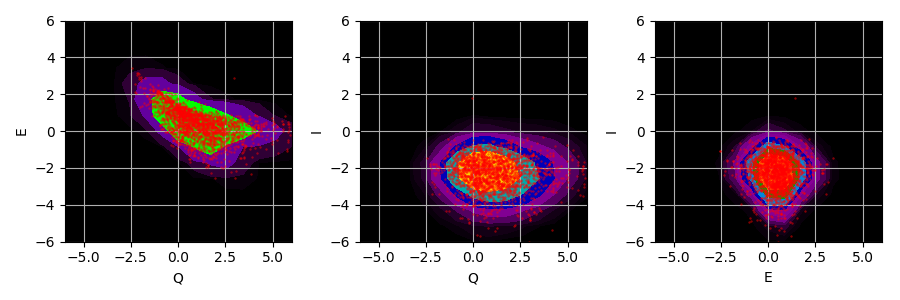

In [42]:
fig,axs=plt.subplots(1,3,figsize=(9,3))

pargs=dict(color='r',ls='None',marker='+',ms=2,alpha=0.5)
hargs=dict(cmap="nipy_spectral")

i=-1

i+=1
levels=np.logspace(np.log10(PXY.min()),np.log10(PXY.max()),100)
axs[i].contourf(Xxy,Yxy,PXY,levels=levels,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,1],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("E")

i+=1
levels=np.logspace(np.log10(PXZ.min()),np.log10(PXZ.max()),100)
axs[i].contourf(Xxz,Zxz,PXZ,levels=levels,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,2],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("I")

i+=1
levels=np.logspace(np.log10(PYZ.min()),np.log10(PYZ.max()),100)
axs[i].contourf(Yyz,Zyz,PYZ,levels=levels,**hargs)
axs[i].plot(data[:ndata,1],data[:ndata,2],**pargs)
axs[i].set_xlabel("E")
axs[i].set_ylabel("I")

for ax in axs:
    ax.grid()
    ax.set_xlim((-vmax,vmax))
    ax.set_ylim((-vmax,vmax))
    
fig.tight_layout()

In [43]:
## Draw distribution fit parameters

## Multivariate rejection

In [104]:
vmax=10

def multiNorm3DMax(params):
    
    #Find position of the maximum and maximum value
    imultiNorm3D=lambda r,params:-multiNorm3D(r,params)
    solution=minimize(imultiNorm3D,[0,0,0],args=(params,))
    
    #Find range
    N=len(params)
    if N>9:
        M=np.int((len(params)+1)/10)
        i=0;j=i+M-1
        weights=list(params[i:j])+[1-sum(params[i:j])]
    else:
        #Case for one function
        M=1
        weights=[1.0]
        j=0
    i=j;j=i+3*M
    locs=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    scales=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    angles=np.reshape(params[i:j],(M,3))
    
    rmaxs=[]
    rmins=[]
    for i in range(M):
        rmaxs+=[locs[i]+2.5*scales[i]]
        rmins+=[locs[i]-2.5*scales[i]]
    rmaxs=np.array(rmaxs)
    rmins=np.array(rmins)
    vmax=rmaxs.max(axis=0)
    vmin=rmins.min(axis=0)
    
    return solution,vmin,vmax
    
def multiReject(params,N):
    multiNorm3DMax(params)
    solution,vmin,vmax=multiNorm3DMax(params)
    pmax=-solution.fun
    vmin[2]=-7
    i=0
    rs=[]
    while True:
        r=[np.random.uniform(vmin[i],vmax[i]) for i in range(3)] 
        p=multiNorm3D(r,params)
        u=np.random.uniform(0,pmax)
        if u>p:continue
        rs+=[r]
        i+=1
        if i>=N:break
    return np.array(rs),vmin,vmax

In [105]:
elTime(0)
rs,vmin,vmax=multiReject(params,len(data))
elTime(1)

123.683 s, 2.061 min, 0.0343565 h


In [106]:
vmin,vmax

(array([-2.4933245, -1.8074465, -7.       ]),
 array([4.0540425, 2.7313685, 1.7238195]))

In [107]:
vmin,vmax

(array([-2.4933245, -1.8074465, -7.       ]),
 array([4.0540425, 2.7313685, 1.7238195]))

<IPython.core.display.Javascript object>


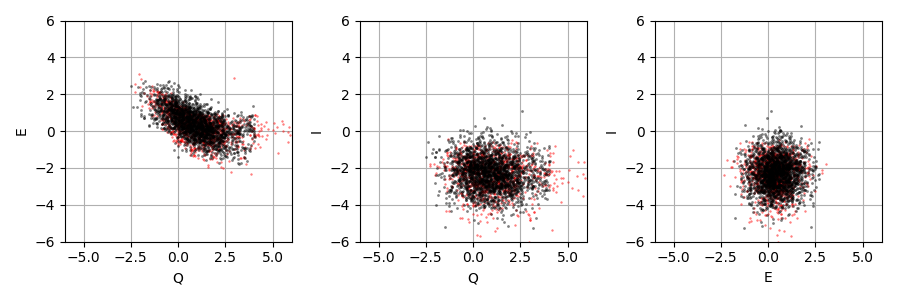

In [108]:
vmax=6
fig,axs=plt.subplots(1,3,figsize=(9,3))

pargs=dict(color='r',ls='None',marker='+',ms=2,alpha=0.5)
hargs=dict(cmap="nipy_spectral")
targs=dict(color='k',ls='None',marker='o',ms=2,mec='None',alpha=0.5)

i=-1

i+=1
levels=np.logspace(np.log10(PXY.min()),np.log10(PXY.max()),100)
#axs[i].contourf(Xxy,Yxy,PXY,levels=levels,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,1],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("E")
axs[i].plot(rs[:,0],rs[:,1],**targs)

i+=1
levels=np.logspace(np.log10(PXZ.min()),np.log10(PXZ.max()),100)
#axs[i].contourf(Xxz,Zxz,PXZ,levels=levels,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,2],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("I")
axs[i].plot(rs[:,0],rs[:,2],**targs)

i+=1
levels=np.logspace(np.log10(PYZ.min()),np.log10(PYZ.max()),100)
#axs[i].contourf(Yyz,Zyz,PYZ,levels=levels,**hargs)
axs[i].plot(data[:ndata,1],data[:ndata,2],**pargs)
axs[i].set_xlabel("E")
axs[i].set_ylabel("I")
axs[i].plot(rs[:,1],rs[:,2],**targs)

for ax in axs:
    ax.grid()
    ax.set_xlim((-vmax,vmax))
    ax.set_ylim((-vmax,vmax))
    
fig.tight_layout()

<IPython.core.display.Javascript object>


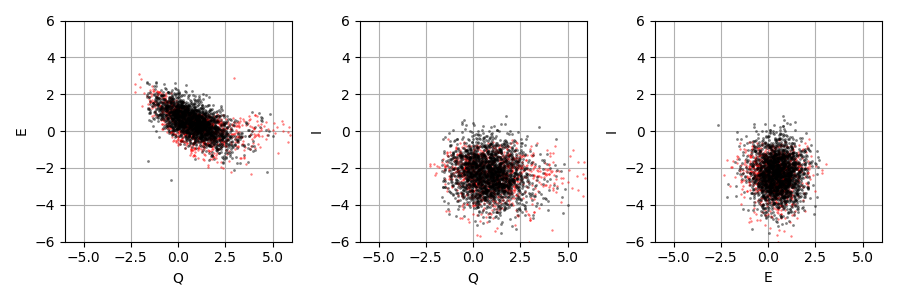

In [83]:
vmax=6
fig,axs=plt.subplots(1,3,figsize=(9,3))

pargs=dict(color='r',ls='None',marker='+',ms=2,alpha=0.5)
hargs=dict(cmap="nipy_spectral")
targs=dict(color='k',ls='None',marker='o',ms=2,mec='None',alpha=0.5)

i=-1

i+=1
levels=np.logspace(np.log10(PXY.min()),np.log10(PXY.max()),100)
#axs[i].contourf(Xxy,Yxy,PXY,levels=levels,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,1],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("E")
axs[i].plot(rs[:,0],rs[:,1],**targs)

i+=1
levels=np.logspace(np.log10(PXZ.min()),np.log10(PXZ.max()),100)
#axs[i].contourf(Xxz,Zxz,PXZ,levels=levels,**hargs)
axs[i].plot(data[:ndata,0],data[:ndata,2],**pargs)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("I")
axs[i].plot(rs[:,0],rs[:,2],**targs)

i+=1
levels=np.logspace(np.log10(PYZ.min()),np.log10(PYZ.max()),100)
#axs[i].contourf(Yyz,Zyz,PYZ,levels=levels,**hargs)
axs[i].plot(data[:ndata,1],data[:ndata,2],**pargs)
axs[i].set_xlabel("E")
axs[i].set_ylabel("I")
axs[i].plot(rs[:,1],rs[:,2],**targs)

for ax in axs:
    ax.grid()
    ax.set_xlim((-vmax,vmax))
    ax.set_ylim((-vmax,vmax))
    
fig.tight_layout()

In [109]:
teo=pd.DataFrame(rs,columns=["Qt","Et","It"])

In [110]:
teo["q"]=map2Fin(teo["Qt"])
teo["e"]=map2Fin(teo["Et"])
teo["i"]=map2Fin(teo["It"],180)

<IPython.core.display.Javascript object>


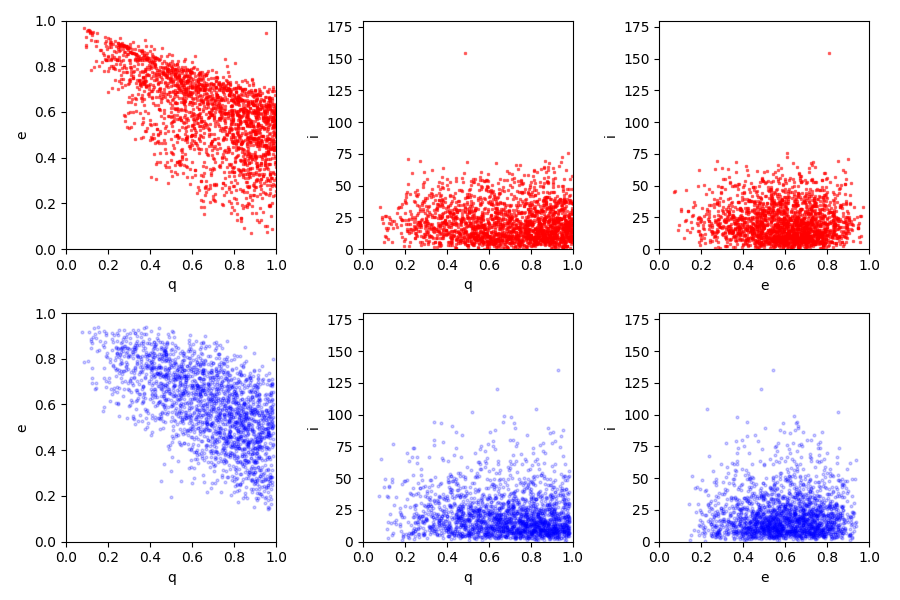

In [111]:
#Plot
fig,axs=plt.subplots(2,3,figsize=(9,6))

qcont=0
pargs=dict(color='w' if qcont else 'r',ls='None',marker='s',ms=2,alpha=0.5)
targs=dict(color='w' if qcont else 'b',ls='None',marker='o',ms=2,alpha=0.2)
hargs=dict(cmap="nipy_spectral")
pairs=[["q","e"],["q","i"],["e","i"]]

qmin=dict(q=0.0,e=0.0,i=0)
qmax=dict(q=1.0,e=1.0,i=180)

for n,pair in enumerate(pairs):
    q1=pair[0]
    q2=pair[1]
    ax=axs[0,n]
    if qcont:ax.hist2d(neos[q1],neos[q2],**hargs)
    ax.plot(neos[q1],neos[q2],**pargs)
    ax.set_xlabel(q1);ax.set_ylabel(q2)
    ax.set_xlim((qmin[q1],qmax[q1]))
    ax.set_ylim((qmin[q2],qmax[q2]))
    
for n,pair in enumerate(pairs):
    q1=pair[0]
    q2=pair[1]
    ax=axs[1,n]
    ax.plot(teo[q1],teo[q2],**targs)
    ax.set_xlabel(q1);ax.set_ylabel(q2)
    ax.set_xlim((qmin[q1],qmax[q1]))
    ax.set_ylim((qmin[q2],qmax[q2]))
    
fig.tight_layout()

In [315]:
unflattenParameters(params)

([0.3555974205766381, 0.6444025794233619],
 array([[ 2.12509345,  0.33908486, -2.6369481 ],
        [ 0.49089339,  0.46506795, -2.07382922]]),
 array([[1.5564864 , 0.92791572, 0.44030776],
        [1.30714097, 0.5055617 , 0.73985149]]),
 array([[-0.16344599, -1.55660987, -0.28707826],
        [ 2.32714378, -0.11060425, -3.03320251]]),
 [array([[ 0.9456395 ,  0.28159141,  0.16270285],
         [-0.16002323, -0.03265006,  0.98657313],
         [ 0.28312278, -0.95897875,  0.01418598]]),
  array([[ 0.76044425,  0.64442149, -0.0802838 ],
         [-0.64929344,  0.75675625, -0.07574964],
         [ 0.01194057,  0.10973113,  0.99388958]])],
 [array([[ 2.23982235, -0.34340221,  0.41655653],
         [-0.34340221,  0.25165544, -0.0800884 ],
         [ 0.41655653, -0.0800884 ,  0.98607065]]),
  array([[ 1.09772197, -0.71565866, -0.01008901],
         [-0.71565866,  0.86983601, -0.03323295],
         [-0.01008901, -0.03323295,  0.5440324 ]])])

## Test C-code

In [324]:
array=np.array

In [325]:
weights=[]
locs=[[ 2.12509345,  0.33908486, -2.6369481 ]]
scales=[[1.5564864 , 0.92791572, 0.44030776]]
angles=[[-0.16344599, -1.55660987, -0.28707826]]
params,bnds=flattenParams(weights,locs,scales,angles)

In [323]:
multiNorm3D([0,0,0],params)

9.048676890568133e-05

In [17]:
weights=[0.8]
locs=[[0,0,0],[1.5,1.5,1.5]]
scales=[[1.0,0.2,0.4],[0.2,0.2,1.0]]
angles=[[30*DEG,-45*DEG,60*DEG],[0.0,0.0,0.0]]
params,bnds=flattenParams(weights,locs,scales,angles)

In [18]:
multiNorm3D([0,0,0],params)

0.6349363593424098

In [20]:
%timeit -n 100 multiNorm3D([0,0,0],params)

100 loops, best of 3: 1.05 ms per loop


In [329]:
neos

,q,e,i,sini,a,W,w,Q,E,I
0,0.647080,0.559823,6.35515,0.110691,1.470045,35.63058,285.97066,0.606226,0.240445,-3.307747
1,0.441526,0.764423,1.32368,0.023101,1.874230,349.57126,43.54919,-0.234972,1.177083,-4.905160
2,0.622603,0.623851,6.06703,0.105692,1.655203,34.21673,92.74609,0.500610,0.505927,-3.355801
3,0.624233,0.712903,2.52241,0.044010,2.174290,74.98772,98.26054,0.507553,0.909524,-4.253630
4,0.888658,0.606568,18.40014,0.315651,2.258733,346.44391,268.06189,2.077108,0.432908,-2.172765
5,0.771148,0.436061,9.38341,0.163040,1.367432,274.24583,127.22061,1.214803,-0.257162,-2.900476
6,0.186588,0.826928,22.82647,0.387941,1.078095,88.00473,31.38078,-1.472333,1.564009,-1.929430
7,0.835580,0.508022,12.16957,0.210806,1.698408,356.66976,224.67229,1.625701,0.032090,-2.624016
8,0.827577,0.335440,13.33737,0.230684,1.245302,337.19539,276.91504,1.568555,-0.683680,-2.525402
9,0.725107,0.634287,6.70421,0.116744,1.982719,294.87387,236.35892,0.969935,0.550651,-3.252264


In [24]:
neos.head(1)

,q,e,i,sini,a,W,w,Q,E,I
0,0.64708,0.559823,6.35515,0.110691,1.470045,35.63058,285.97066,0.606226,0.240445,-3.307747


In [25]:
data.shape

(2172, 3)

In [35]:
def logLikelihood(params,data,pdf,**args):
    logL=0
    i=0
    for point in data:
        p=pdf(point,params,**args)
        #print(f"x[{i}]={point}, p = {p}")
        logp=np.log10(p)
        logL-=logp
        i+=1
    return logL

In [37]:
logLikelihood(params,data,multiNorm3D)

32331.510108566854

In [40]:
%timeit -n 1 logLikelihood(params,data,multiNorm3D)

1 loop, best of 3: 2.37 s per loop


### Create list of dates

In [19]:
f=open("year.sh","w")
tini=0
DAY=86400
YEAR=365*DAY
for i,t in enumerate(np.arange(tini,tini+YEAR,DAY)):
    f.write(f"python makeagravray.py ET{t:.0f} rad util/data/directions/directions-r3.00e+01-sample1.data rad util/data/directions/directions-r3.00e+01-sample0.data 0 util/data/vel\
ocities/velocities.earth.regular20.dat YearTest 80000\n")
f.close()

In [25]:
date="01/01/2000 12:00:00 UTC"

In [26]:
spy.furnsh("../GravRay/util/kernels/naif0011.tls")

In [31]:
et=spy.str2et(date)
dt=spy.deltet(et,"ET")
t=et-dt
print(t)

6.16608986092615e-11


In [39]:
dstr=spy.et2utc(et,"C",0)
dstr

'2000 JAN 01 12:00:00'

In [40]:
spy.str2et(dstr)

64.18392728473108

In [44]:
spy.deltet(t,"UTC")

64.18392728466942

In [47]:
spy.deltet(et,"ET")

64.18392728466942

In [49]:
ddt=spy.deltet(t,"UTC")
spy.et2utc(t+ddt,"C",0)

'2000 JAN 01 12:00:00'